# LSTM - Temp

## Import Data

In [1]:
import pandas as pd

In [7]:
df = pd.read_csv("../data/data_imputed_2.csv")

In [8]:
df.head()

,timestamp_local,temp,city_name,country_code,aqi,co,no2,o3,pm10,pm25,so2
0,01/02/2022 0:00,12.6,Gujrāt,PK,385,1339.8,76.0,10.7,491.7,347.67,238.0
1,01/02/2022 1:00,11.5,Gujrāt,PK,404,1437.6,76.0,9.3,508.3,359.33,268.0
2,01/02/2022 2:00,11.9,Gujrāt,PK,421,1535.5,76.0,8.0,525.0,371.00,298.0
3,01/02/2022 3:00,12.2,Gujrāt,PK,425,1659.0,68.3,5.3,529.3,374.00,275.7
4,01/02/2022 4:00,11.9,Gujrāt,PK,430,1782.5,60.7,2.7,533.7,377.00,253.3


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19706 entries, 0 to 19705
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   timestamp_local  19706 non-null  object 
 1   temp             19706 non-null  float64
 2   city_name        19706 non-null  object 
 3   country_code     19706 non-null  object 
 4   aqi              19706 non-null  int64  
 5   co               19706 non-null  float64
 6   no2              19706 non-null  float64
 7   o3               19706 non-null  float64
 8   pm10             19706 non-null  float64
 9   pm25             19706 non-null  float64
 10  so2              19706 non-null  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 1.7+ MB


In [10]:
data = df[['temp']]

## Data PreProcessing

In [11]:
from sklearn.metrics import mean_absolute_error , mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

In [12]:
dataset = data
values = dataset.values

values = values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [13]:
def series_to_supervised(data, n_in = 1, n_out = 1, dropnan = True):
    n_vars = 1 if type(data) is list else data.shape[1]
    
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

In [14]:
# converting the dataset as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
print(reframed.shape)

(19705, 2)


In [15]:
reframed.head()

,var1(t-1),var1(t)
1,0.221709,0.196305
2,0.196305,0.205543
3,0.205543,0.212471
4,0.212471,0.205543
5,0.205543,0.196305


In [16]:
reframed.columns

Index(['var1(t-1)', 'var1(t)'], dtype='object')

In [18]:
values = reframed.values

# We train the model on the 1st 1 and a half years of data and then test on the remaining 
n_train_hours = int(365 * 24 * 1.5)

train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D :- (no.of samples, no.of timesteps, no.of features)
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(13140, 1, 1) (13140,) (6565, 1, 1) (6565,)


In [19]:
train.shape, test.shape, values.shape

((13140, 2), (6565, 2), (19705, 2))

## Model Fitting

### Model 1

In [20]:
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential

In [23]:
import matplotlib.pyplot as plt

In [21]:
model = Sequential()
model.add(Input(shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(64))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_split=0.2, verbose=2, shuffle=False)

Epoch 1/50
146/146 - 3s - 18ms/step - loss: 0.0775 - val_loss: 0.0361
Epoch 2/50
146/146 - 0s - 3ms/step - loss: 0.0120 - val_loss: 0.0345
Epoch 3/50
146/146 - 0s - 2ms/step - loss: 0.0086 - val_loss: 0.0271
Epoch 4/50
146/146 - 0s - 2ms/step - loss: 0.0061 - val_loss: 0.0194
Epoch 5/50
146/146 - 0s - 3ms/step - loss: 0.0043 - val_loss: 0.0128
Epoch 6/50
146/146 - 0s - 2ms/step - loss: 0.0031 - val_loss: 0.0077
Epoch 7/50
146/146 - 0s - 2ms/step - loss: 0.0023 - val_loss: 0.0043
Epoch 8/50
146/146 - 0s - 2ms/step - loss: 0.0018 - val_loss: 0.0024
Epoch 9/50
146/146 - 0s - 2ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 10/50
146/146 - 0s - 2ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 11/50
146/146 - 0s - 2ms/step - loss: 0.0013 - val_loss: 9.9375e-04
Epoch 12/50
146/146 - 0s - 2ms/step - loss: 0.0012 - val_loss: 9.8460e-04
Epoch 13/50
146/146 - 0s - 2ms/step - loss: 0.0012 - val_loss: 9.9904e-04
Epoch 14/50
146/146 - 0s - 2ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 15/50
146/

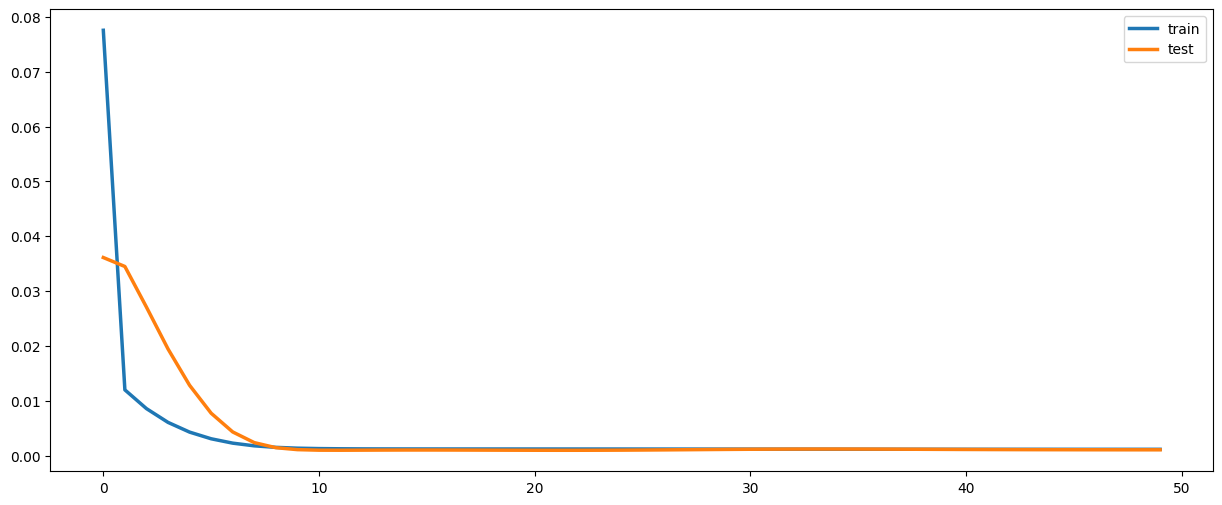

In [24]:
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label='train', linewidth = 2.5)
plt.plot(history.history['val_loss'], label='test',  linewidth = 2.5)
plt.legend()
plt.show()

In [25]:
testPredict = model.predict(test_X)
print(testPredict.shape)
testPredict = testPredict.ravel()

print(testPredict.shape)

206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(6565, 1)
(6565,)


In [26]:
y_test_true = test[:,1]

In [27]:
import numpy as np

In [28]:
poll = np.array(df["temp"])

meanop = poll.mean()
stdop = poll.std()

y_test_true = y_test_true*stdop + meanop
testPredict = testPredict*stdop + meanop

In [29]:
rmse = np.sqrt(mean_squared_error(test_y, testPredict))
print("Test RMSE ="  ,rmse)

Test RMSE = 27.252655


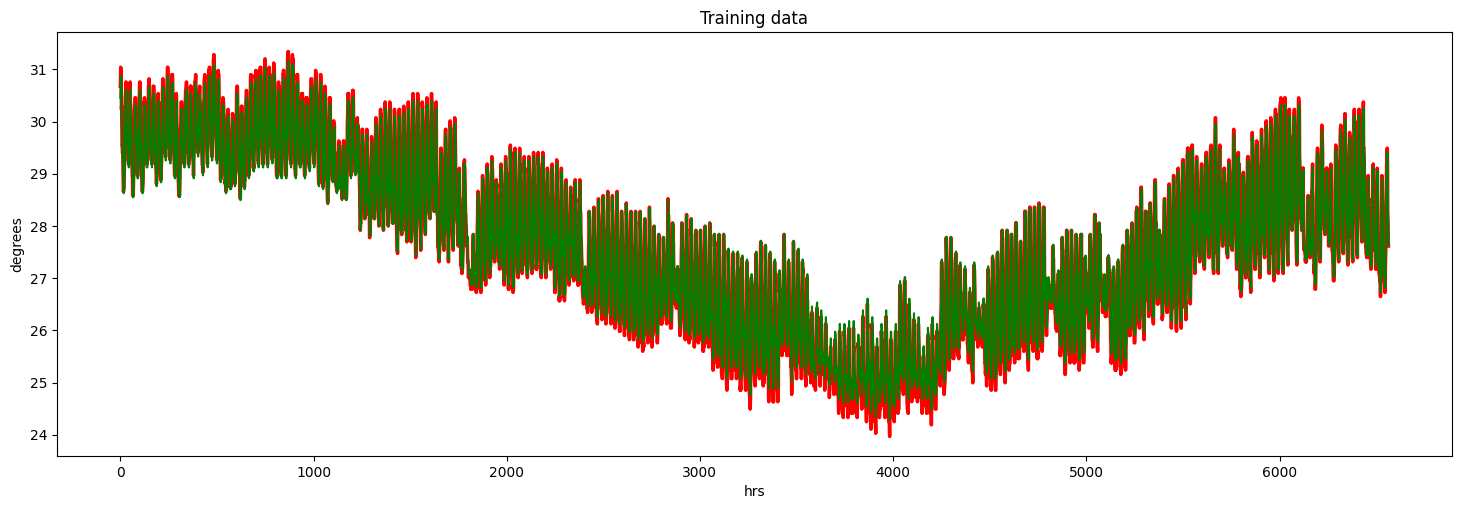

In [30]:
from matplotlib import pyplot as plt

plt.figure(figsize=(18,5.5))
plt.ylabel("degrees")
plt.xlabel("hrs")
plt.plot(y_test_true, c = "red", linewidth = 2.5)
plt.plot(testPredict, c = "green")
plt.title("Training data")
plt.show()

### Model 2

In [31]:
model2 = Sequential()
model2.add(Input(shape=(train_X.shape[1], train_X.shape[2])))
model2.add(LSTM(256))
model2.add(Dense(64))
model2.add(Dropout(0.25))
model2.add(BatchNormalization())
model2.add(Dense(1))

model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 256)                 │         264,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 280,961 (1.07 MB)

 Trainable params: 280,833 (1.07 MB)

 Non-trainable params: 128 (512.00 B)

In [32]:
model2.compile(loss='mse', optimizer='adam')

hist2 = model2.fit(train_X, train_y, epochs=50, batch_size=128, validation_data=(test_X, test_y))

Epoch 1/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.1208 - val_loss: 0.0420
Epoch 2/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0022 - val_loss: 0.0391
Epoch 3/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0024 - val_loss: 0.0359
Epoch 4/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0025 - val_loss: 0.0314
Epoch 5/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0025 - val_loss: 0.0191
Epoch 6/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0022 - val_loss: 0.0100
Epoch 7/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0022 - val_loss: 0.0133
Epoch 8/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0022 - val_loss: 0.0049
Epoch 9/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0023 - val_loss: 0.0013
Epoch 10/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 11/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 12/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/

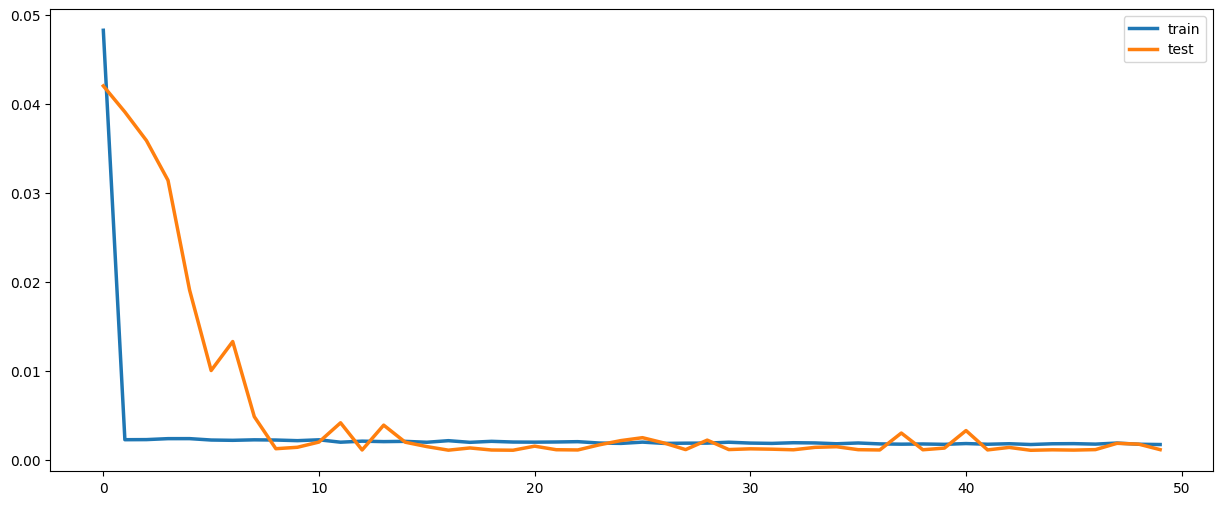

In [33]:
plt.figure(figsize=(15,6))
plt.plot(hist2.history['loss'], label='train', linewidth = 2.5)
plt.plot(hist2.history['val_loss'], label='test',  linewidth = 2.5)
plt.legend()
plt.show()

In [34]:
y_test_true = test[:,1]

In [35]:
testPredict2 = model2.predict(test_X)
testPredict2 = testPredict2.ravel()

# Inverse scaling the output, for better visual interpretation 

poll = np.array(df["temp"])
meanop = poll.mean()
stdop = poll.std()

print(meanop, stdop)

y_test_true = y_test_true*stdop + meanop
testPredict2 = testPredict2*stdop + meanop

206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
23.969638688724245 8.723285922487557


In [36]:
rmse = np.sqrt(mean_squared_error(y_test_true, testPredict2))
print("Test(Validation) RMSE ="  ,rmse)

Test(Validation) RMSE = 0.29560754


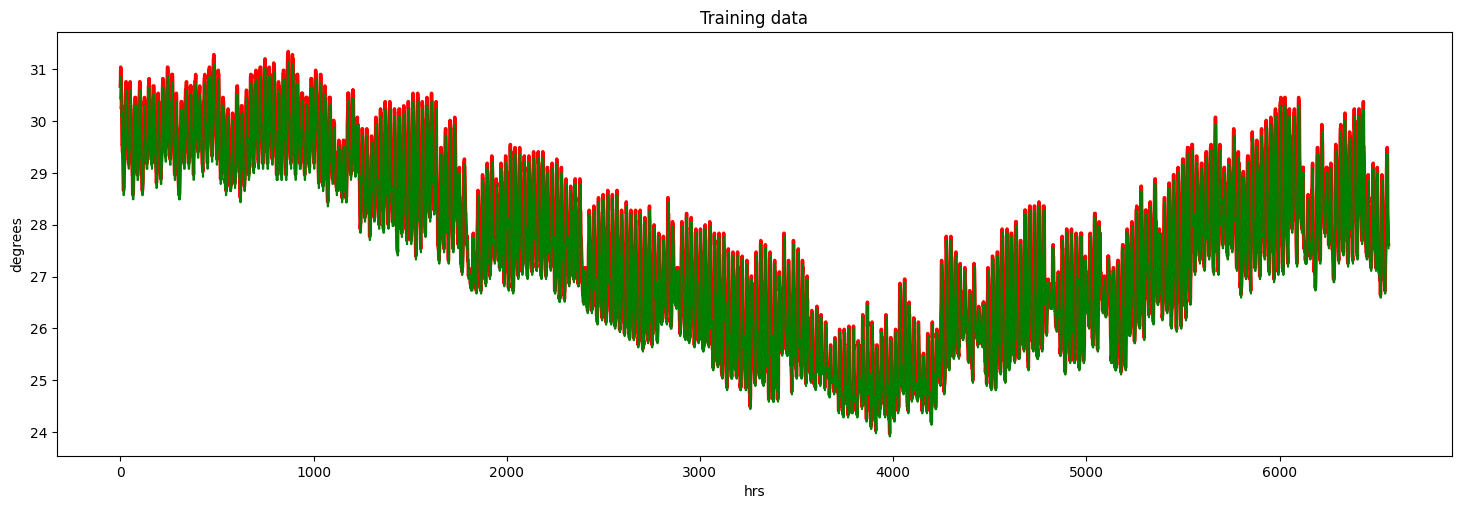

In [37]:
from matplotlib import pyplot as plt

plt.figure(figsize=(18,5.5))
plt.ylabel("degrees")
plt.xlabel("hrs")
plt.plot(y_test_true, c = "red", linewidth = 2.5)
plt.plot(testPredict2, c = "green")
plt.title("Training data")
plt.show()

### Model 3

In [38]:
model3 = Sequential()
model3.add(Input(shape=(train_X.shape[1], train_X.shape[2])))
model3.add(LSTM(256))
model3.add(Dense(32))
model3.add(Dropout(0.25))
model3.add(BatchNormalization())
model3.add(Dense(1))
model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 256)                 │         264,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 272,577 (1.04 MB)

 Trainable params: 272,513 (1.04 MB)

 Non-trainable params: 64 (256.00 B)

In [39]:
model3.compile(loss='mse', optimizer='adam')

hist3 = model3.fit(train_X, train_y, epochs=50, batch_size=256, validation_split=0.2)

Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.1975 - val_loss: 0.0930
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0125 - val_loss: 0.0300
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0023 - val_loss: 0.0324
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0021 - val_loss: 0.0314
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0022 - val_loss: 0.0305
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0021 - val_loss: 0.0280
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0022 - val_loss: 0.0259
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0022 - val_loss: 0.0233
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0022 - val_loss: 0.0212
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0023 - val_loss: 0.0207
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0022 - val_loss: 0.0213
Epoch 12/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0

In [40]:
y_test_true = test[:,1]

In [41]:
testPredict3 = model3.predict(test_X)
testPredict3 = testPredict3.ravel()

# Inverse scaling the output, for better visual interpretation 

poll = np.array(df["temp"])
meanop = poll.mean()
stdop = poll.std()

print(meanop, stdop)

y_test_true = y_test_true*stdop + meanop
testPredict3 = testPredict3*stdop + meanop

206/206 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
23.969638688724245 8.723285922487557


In [42]:
rmse = np.sqrt(mean_squared_error(y_test_true, testPredict3))
print("Training RMSE ="  ,rmse)

Training RMSE = 0.3538301


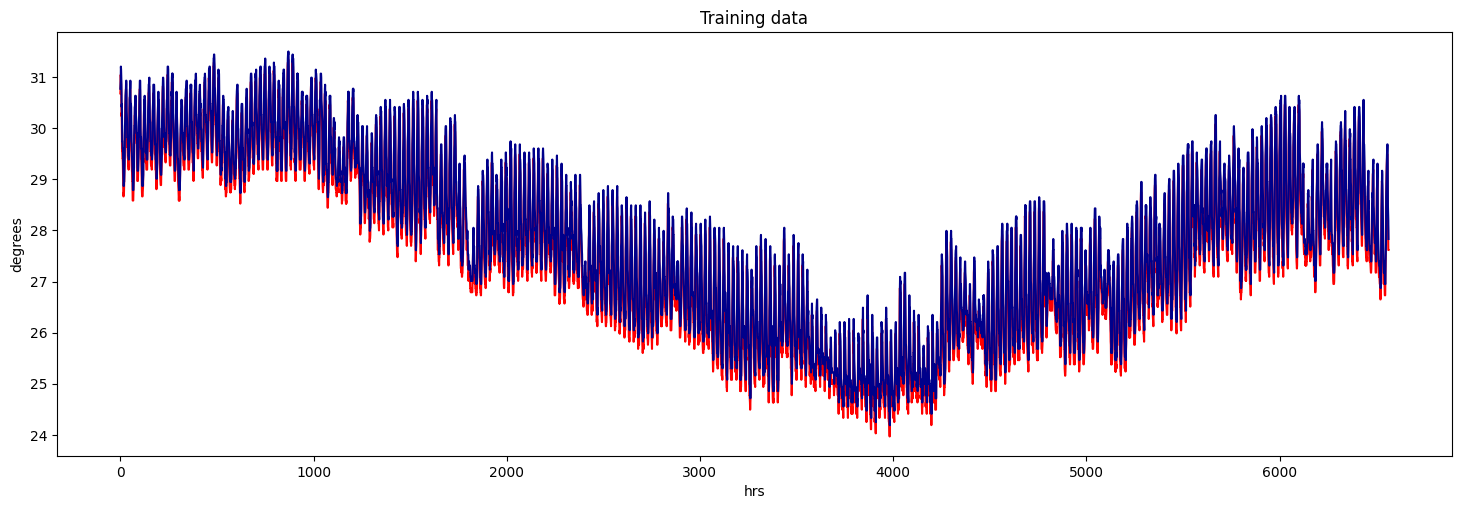

In [43]:
from matplotlib import pyplot as plt

plt.figure(figsize=(18,5.5))
# plt.xlim([1000,1250])
plt.ylabel("degrees")
plt.xlabel("hrs")
plt.plot(y_test_true, c = "red")
plt.plot(testPredict3, c = "darkblue")
plt.title("Training data")
plt.show()

## Saving Best Performing Model

In [44]:
model2.save("temp.h5")

In [45]:
model2.save("temp.keras")

## Forecast

In [86]:
# Assuming you have `model` already trained and `meanop` and `stdop` calculated

# Initialize an array to store forecasted values
forecast_values = []

# Use the last available data point from your dataset as the initial input
last_input = test_X[-1]

# Define the number of time steps you want to forecast
num_steps = 7  # Adjust according to your needs

for _ in range(num_steps):
    # Reshape input data for prediction
    input_data = np.expand_dims(last_input, axis=0)

    # Make prediction
    forecast = model.predict(input_data)

    # Inverse transform forecasted value
    forecast = forecast.ravel() * stdop + meanop

    # Store forecasted value
    forecast_values.append(forecast)

    # Update input data for the next time step by shifting and appending forecasted value
    last_input = np.roll(last_input, -1)
    last_input[-1] = (forecast - meanop) / stdop  # Normalize the forecasted value

# Convert forecast_values to a numpy array
forecast_values = np.array(forecast_values)

# Print or use forecast_values for further analysis
print(forecast_values)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
[[27.132513]
 [27.208662]
 [27.279833]
 [27.346386]
 [27.408646]
 [27.466913]
 [27.521463]]


In [85]:
# Assuming you have `model` already trained and `meanop` and `stdop` calculated

# Initialize an array to store forecasted values
forecast_values = []

# Use the last available data point from your dataset as the initial input
last_input = test_X[-1]

# Define the number of time steps you want to forecast
num_steps = 7  # Adjust according to your needs

for _ in range(num_steps):
    # Reshape input data for prediction
    input_data = np.expand_dims(last_input, axis=0)

    # Make prediction
    forecast = model2.predict(input_data)

    # Inverse transform forecasted value
    forecast = forecast.ravel() * stdop + meanop

    # Store forecasted value
    forecast_values.append(forecast)

    # Update input data for the next time step by shifting and appending forecasted value
    last_input = np.roll(last_input, -1)
    last_input[-1] = (forecast - meanop) / stdop  # Normalize the forecasted value

# Convert forecast_values to a numpy array
forecast_values = np.array(forecast_values)

# Print or use forecast_values for further analysis
print(forecast_values)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
[[27.009602]
 [26.968103]
 [26.926489]
 [26.884745]
 [26.842861]
 [26.800823]
 [26.758621]]


In [87]:
# Assuming you have `model` already trained and `meanop` and `stdop` calculated

# Initialize an array to store forecasted values
forecast_values = []

# Use the last available data point from your dataset as the initial input
last_input = test_X[-1]

# Define the number of time steps you want to forecast
num_steps = 7  # Adjust according to your needs

for _ in range(num_steps):
    # Reshape input data for prediction
    input_data = np.expand_dims(last_input, axis=0)

    # Make prediction
    forecast = model3.predict(input_data)

    # Inverse transform forecasted value
    forecast = forecast.ravel() * stdop + meanop

    # Store forecasted value
    forecast_values.append(forecast)

    # Update input data for the next time step by shifting and appending forecasted value
    last_input = np.roll(last_input, -1)
    last_input[-1] = (forecast - meanop) / stdop  # Normalize the forecasted value

# Convert forecast_values to a numpy array
forecast_values = np.array(forecast_values)

# Print or use forecast_values for further analysis
print(forecast_values)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[[27.136915]
 [27.216236]
 [27.289446]
 [27.356995]
 [27.419304]
 [27.476767]
 [27.529747]]
